In [1]:
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm#_notebook as tqdm
import scipy
import scipy.special
import itertools
import yaml

In [2]:
import matplotlib
matplotlib.rcParams['font.family']
matplotlib.rcParams['font.sans-serif'] = ['Arial']

In [15]:
path = './'

def get_ys(model_name, outcome):
    y_true = np.load(path + outcome + '_test.npy')
    y_score = None
    if model_name == 'xgb' or model_name == 'linear_svc':
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npy')
    else:
        y_score = np.load(path + model_name + '_' + outcome + '_y_score.npz')['y_score']      
    return y_true, y_score

def get_roc_CI(y_true, y_score):
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)
    roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
        # roc_curves, auc_scores = [], []
        # for i in range(1000):
        #     yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        #     roc_curves.append(metrics.roc_curve(yte_true_b, yte_pred_b))
        #     auc_scores.append(metrics.roc_auc_score(yte_true_b, yte_pred_b))
    print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
    print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
#         print('Test AUC: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
#         print('Test AUC: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(auc_scores), np.mean(auc_scores) - 1.96 * np.std(auc_scores), np.mean(auc_scores) + 1.96 * np.std(auc_scores)))
#         print('Test AUC: {:.3f} ± {:.3f} SE'.format(np.mean(auc_scores), np.std(auc_scores)))
        
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for fpr, tpr, _ in roc_curves:
        tprs.append(scipy.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(metrics.auc(fpr, tpr))

    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)
    return roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper

def graph_ROC(model_name, outcome):
    y_true, y_score = get_ys(model_name, outcome)
    
    fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    
    roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_score)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    plt.plot(fpr, tpr, '-', color='blue')
    plt.plot(mean_fpr, tprs_lower, '--', color='skyblue')
    plt.plot(mean_fpr, tprs_upper, '--', color='skyblue')
    
    # random dashed line
    plt.plot([0,0.5,1],[0,0.5,1],'--',color='black')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt_title = 'ROC of ' + model_name + ' on outcome ' +  outcome
    plt_title = plt_title.replace("_"," ",1)
    plt_title = plt_title.replace("linear_svc","linear model",1)
    plt_title = plt_title.replace("xgb","non-linear model",1)
    #patches = [mpatches.Patch(color='blue', label='Baseline Features'),
    #           mpatches.Patch(color='magenta', label='All Features')]
               
    #plt.legend(handles=patches)
    
    
    #plt.title(plt_title)
    # plotting code ...
    plt.tight_layout()
    plt.savefig(path + "/figs/" + plt_title + '.svg', format='svg')
    #plt.show()
    #plt.close()

def get_pr_CI(y_true, y_score):
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return (
            metrics.precision_recall_curve(yte_true_b, yte_pred_b), 
            metrics.auc(*metrics.precision_recall_curve(yte_true_b, yte_pred_b)[1::-1])
        )
    curves, scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
    print('Test AUPR: {:.3f}'.format(metrics.auc(*metrics.precision_recall_curve(y_true, y_score)[1::-1])))
    print('Test AUPR: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(scores), np.mean(scores) - 1.96 * np.std(scores), np.mean(scores) + 1.96 * np.std(scores)))
#         print('Test AUPR: {:.3f} ± {:.3f} SE'.format(np.mean(scores), np.std(scores)))
        
    precs = []
    mean_rec = np.linspace(0, 1, 101)
    for prec, rec, _ in curves:
        rec_sorted, prec_sorted = rec[np.argsort(rec)], prec[np.argsort(rec)]
        precs.append(np.interp(mean_rec, rec_sorted, prec_sorted))
        
    mean_prec = np.mean(precs, axis=0)
    std_prec = np.std(precs, axis=0)
    prec_upper = np.minimum(mean_prec + 1.96 * std_prec, 1)
    prec_lower = np.maximum(mean_prec - 1.96 * std_prec, 0)
    return curves, scores, mean_rec, prec_lower, prec_upper

def graph_PR(model_name, outcome):
    y_true, y_score = get_ys(model_name, outcome)
    
    precision, recall, _ = metrics.precision_recall_curve(y_true, y_score)
    
    curves, scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_score)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    
    plt.plot(recall, precision, '-', color='blue')
    plt.plot(mean_rec, prec_lower, '--', color='skyblue')
    plt.plot(mean_rec, prec_upper, '--', color='skyblue')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt_title = 'PR of ' + model_name + ' on outcome ' +  outcome
    plt_title = plt_title.replace("_"," ",1)
    plt_title = plt_title.replace("linear_svc","linear model",1)
    plt_title = plt_title.replace("xgb","non-linear model",1)
    patches = [mpatches.Patch(color='blue', label='Baseline Features'),
               mpatches.Patch(color='magenta', label='All Features')]
               
    plt.legend(handles=patches, loc="top right")
    
    
    #plt.title(plt_title)
    # plotting code ...
    plt.tight_layout()
    plt.savefig(path + "/figs/" + plt_title + '.svg', format='svg')
    #plt.show()
    #plt.close()

def graph_PR_multiple_model(model_names, outcome):
    color_schemes_by_outcome = {
        'refill' : [['forestgreen', 'limegreen'], ['blue', 'skyblue']],
        'prolonged_use' : [['purple', 'magenta'], ['orangered', 'coral']]
        }

    color_schemes = color_schemes_by_outcome[outcome]

    fig, ax = plt.subplots(figsize=(3, 3))

    for model_name, color_scheme in zip(model_names, color_schemes):
        print(model_name)
        y_true, y_score = get_ys(model_name, outcome)
    
        precision, recall, _ = metrics.precision_recall_curve(y_true, y_score)
    
        curves, scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_score)
        
        plt.plot(recall, precision, '-', color=color_scheme[0], alpha=0.7)
        plt.plot(mean_rec, prec_lower, '--', color=color_scheme[1], alpha=0.7)
        plt.plot(mean_rec, prec_upper, '--', color=color_scheme[1], alpha=0.7)
    
    # random dashed line
    #plt.plot([0,0.5,1],[0,0.5,1],'--',color='black')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt_title = 'PR ' +  outcome
    plt_title = plt_title.replace("_"," ",1)

    patches = [mpatches.Patch(color=color_schemes[1][0], label="SVM"),
               mpatches.Patch(color=color_schemes[0][0], label="XGB"),
               ]
               
    plt.legend(handles=patches, loc="upper right", title=outcome.replace("_", " "))
    
    #plt.title(plt_title)
    # plotting code ...
    plt.tight_layout()
    plt.savefig(path + "/figs/" + plt_title + '.svg', format='svg')
    #plt.show()
    #plt.close()

def graph_ROC_multiple_model(model_names, outcome):
    
    color_schemes_by_outcome = {
        'refill' : [['forestgreen', 'limegreen'], ['blue', 'skyblue']],
        'prolonged_use' : [['purple', 'magenta'], ['orangered', 'coral']]
        }

    color_schemes = color_schemes_by_outcome[outcome]

    fig, ax = plt.subplots(figsize=(3, 3))

    for model_name, color_scheme in zip(model_names, color_schemes):
        print(model_name)
        y_true, y_score = get_ys(model_name, outcome)
    
        fpr, tpr, _ = metrics.roc_curve(y_true, y_score)
    
        roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_score)
    
        plt.plot(fpr, tpr, '-', color=color_scheme[0], alpha=0.7)
        plt.plot(mean_fpr, tprs_lower, '--', color=color_scheme[1], alpha=0.7)
        plt.plot(mean_fpr, tprs_upper, '--', color=color_scheme[1], alpha=0.7)
    
    # random dashed line
    plt.plot([0,0.5,1],[0,0.5,1],'--',color='black')
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.gca().set_aspect('equal', adjustable='box')
    
    plt_title = 'ROC ' +  outcome
    plt_title = plt_title.replace("_"," ",1)

    patches = [#mpatches.Patch(color='w', label='Model            AUROC (95% CI)'),
               mpatches.Patch(color=color_schemes[1][0], label="SVM"),
               mpatches.Patch(color=color_schemes[0][0], label="XGB"),
               ]
    
    plt.legend(handles=patches, loc="lower right", title=outcome.replace("_", " "))
#     plt.legend(handles=patches, title=outcome.replace("_", " "), bbox_to_anchor=(0.5, -0.4), loc='center')

    
    #plt.title(plt_title)
    # plotting code ...
    plt.tight_layout()
    plt.savefig(path + "/figs/" + plt_title + '.svg', format='svg')
    #plt.show()
    #plt.close()

xgb
Test AUC: 0.660
Test AUC: (0.642, 0.675) percentile 95% CI
linear_svc


<ipython-input-15-35d66de69fbf>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


Test AUC: 0.660
Test AUC: (0.643, 0.675) percentile 95% CI


<ipython-input-15-35d66de69fbf>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


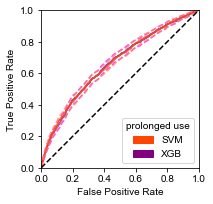

In [16]:
model_names = ['xgb', 'linear_svc']

graph_ROC_multiple_model(model_names, outcome='prolonged_use')
graph_ROC_multiple_model(model_names, outcome='refill')
graph_PR_multiple_model(model_names, outcome='prolonged_use')
graph_PR_multiple_model(model_names, outcome='refill')

#graph_ROC(model_name='xgb', outcome='prolonged_use')
#graph_ROC(model_name='xgb', outcome='refill')

#graph_ROC(model_name='linear_svc', outcome='prolonged_use')
#graph_ROC(model_name='linear_svc', outcome='refill')

#graph_ROC(model_name='CNN', outcome='prolonged_use')
#graph_ROC(model_name='CNN', outcome='refill')

#graph_ROC(model_name='RNN', outcome='prolonged_use')
#graph_ROC(model_name='RNN', outcome='refill')

#graph_PR(model_name='RNN', outcome='refill')
#graph_PR(model_name='RNN', outcome='prolonged_use')

#graph_PR(model_name='CNN', outcome='refill')
#graph_PR(model_name='CNN', outcome='prolonged_use')

#graph_PR(model_name='xgb', outcome='refill')
#graph_PR(model_name='xgb', outcome='prolonged_use')

#graph_PR(model_name='linear_svc', outcome='refill')
#graph_PR(model_name='linear_svc', outcome='prolonged_use')

In [30]:
y_true, y_score_SVM = get_ys('linear_svc', 'refill')
y_true_, y_score_XGB = get_ys('xgb', 'refill')

bootstrap_auc_scores_SVM = np.array(get_roc_CI(y_true, y_score_SVM)[1])
bootstrap_auc_scores_XGB = np.array(get_roc_CI(y_true, y_score_XGB)[1])

pvalue = 2 * min(
    (bootstrap_auc_scores_SVM < bootstrap_auc_scores_XGB).mean(),
    (bootstrap_auc_scores_SVM > bootstrap_auc_scores_XGB).mean(),
)
pvalue

Test AUC: 0.666
Test AUC: (0.654, 0.678) percentile 95% CI


<ipython-input-12-23974ffcfacc>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


Test AUC: 0.681
Test AUC: (0.669, 0.693) percentile 95% CI


<ipython-input-12-23974ffcfacc>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


0.0

In [31]:
np.mean(bootstrap_auc_scores_SVM), np.mean(bootstrap_auc_scores_XGB)

(0.6662063072701175, 0.681080635114122)

In [32]:
y_true, y_score_SVM = get_ys('linear_svc', 'prolonged_use')
y_true_, y_score_XGB = get_ys('xgb', 'prolonged_use')

bootstrap_auc_scores_SVM = np.array(get_roc_CI(y_true, y_score_SVM)[1])
bootstrap_auc_scores_XGB = np.array(get_roc_CI(y_true, y_score_XGB)[1])

pvalue = 2 * min(
    (bootstrap_auc_scores_SVM < bootstrap_auc_scores_XGB).mean(),
    (bootstrap_auc_scores_SVM > bootstrap_auc_scores_XGB).mean(),
)
pvalue

Test AUC: 0.660
Test AUC: (0.643, 0.675) percentile 95% CI


<ipython-input-12-23974ffcfacc>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


Test AUC: 0.660
Test AUC: (0.642, 0.675) percentile 95% CI


<ipython-input-12-23974ffcfacc>:32: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(scipy.interp(mean_fpr, fpr, tpr))


0.808

In [33]:
np.mean(bootstrap_auc_scores_SVM), np.mean(bootstrap_auc_scores_XGB)

(0.6595761406870354, 0.6590942993482636)